### Statisitical Baseline Model for Predciting Stock Prices

This notebook is a simple statistical model for predicting stock prices. The model uses the historical stock prices to predict the future stock prices.

In [13]:
# Stock symbel used for analysis
stock="TSLA"

In [14]:
import pandas as pd
df = pd.read_csv(f'./data/{stock}_daily_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
df.head()

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient
Date,,,,,,,,
2024-11-14,327.69,329.9800,310.37,311.18,311.18,117753376,0.0,1.0
2024-11-13,335.85,344.5999,322.50,330.24,330.24,125405599,0.0,1.0
2024-11-12,342.74,345.8400,323.31,328.49,328.49,155726016,0.0,1.0
2024-11-11,346.30,358.6400,336.00,350.00,350.00,210521625,0.0,1.0
2024-11-08,299.14,328.7100,297.66,321.22,321.22,204782763,0.0,1.0


### Steps:
For simple time series forecasting, we can use the historical stock prices to predict the future stock prices. T
 We will take the adjusted close prices of the stock and use it to predict the future stock prices. Since daily stock prices are noisy and we are interested in predicting the long term trends, we will use the weekly stock prices for prediction.


In [15]:
ts=df['Adjusted Close']

# define the frequency of the current series (this also will add any missing timestamp as NaN)
ts = ts.asfreq('d')

# resample to weekly data and use 'maximum' as the aggregation criteria
ts_w = ts.resample('W').mean()

# reverse the order of the time series
ts_w = ts_w.sort_index(ascending=True)
# split the data into training and test set
length = len(ts_w)
train = ts_w.iloc[:int(length*0.8)]
test = ts_w.iloc[int(length*0.8):]

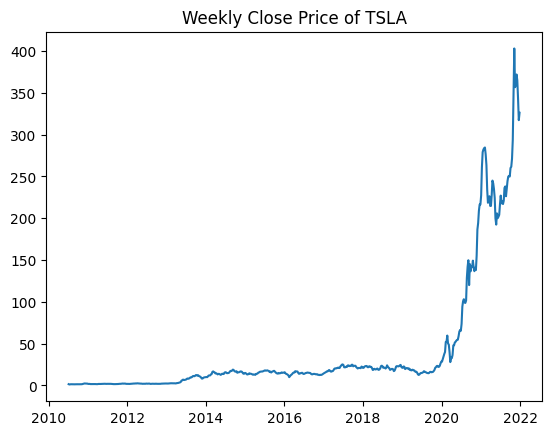

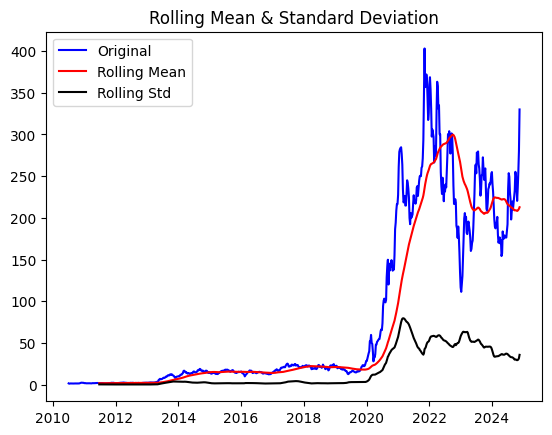

Results of Dickey-Fuller Test:
Test Statistic                  -0.353961
p-value                          0.917507
#Lags Used                      20.000000
Number of Observations Used    730.000000
Critical Value (1%)             -3.439340
Critical Value (5%)             -2.865507
Critical Value (10%)            -2.568883
dtype: float64


In [16]:
# Using Close price for analysis and ARIMA model
ts =train

# Plot the time series data
import matplotlib.pyplot as plt
plt.plot(ts)
plt.title('Weekly Close Price of '+stock)
plt.show()




# Check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts_w, 52)

### Staoinarity:
The time series data should be stationary for the model to work. We will check the stationarity of the time series data using the Augmented Dickey-Fuller test. If the data is not stationary, we will difference the data to make it stationary.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
From, ADF test p-vlaue=0.99, we can see that the data is non-stationary.

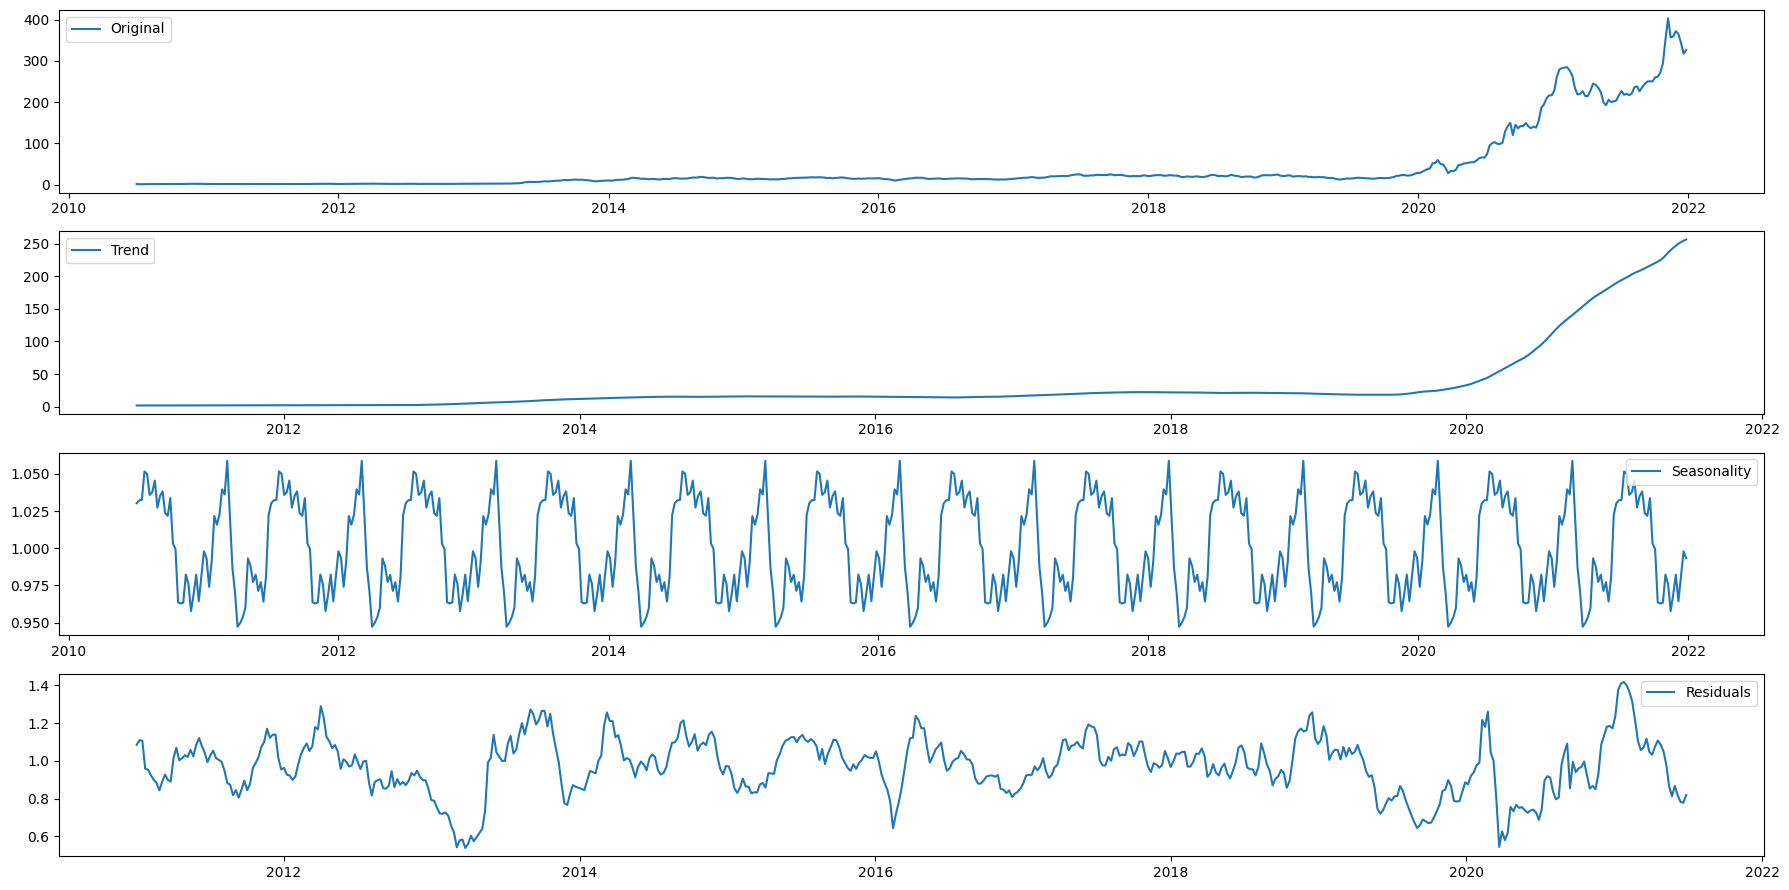

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(train, model='multiplicative',period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize decomposition
plt.figure(figsize=(18,9))
plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

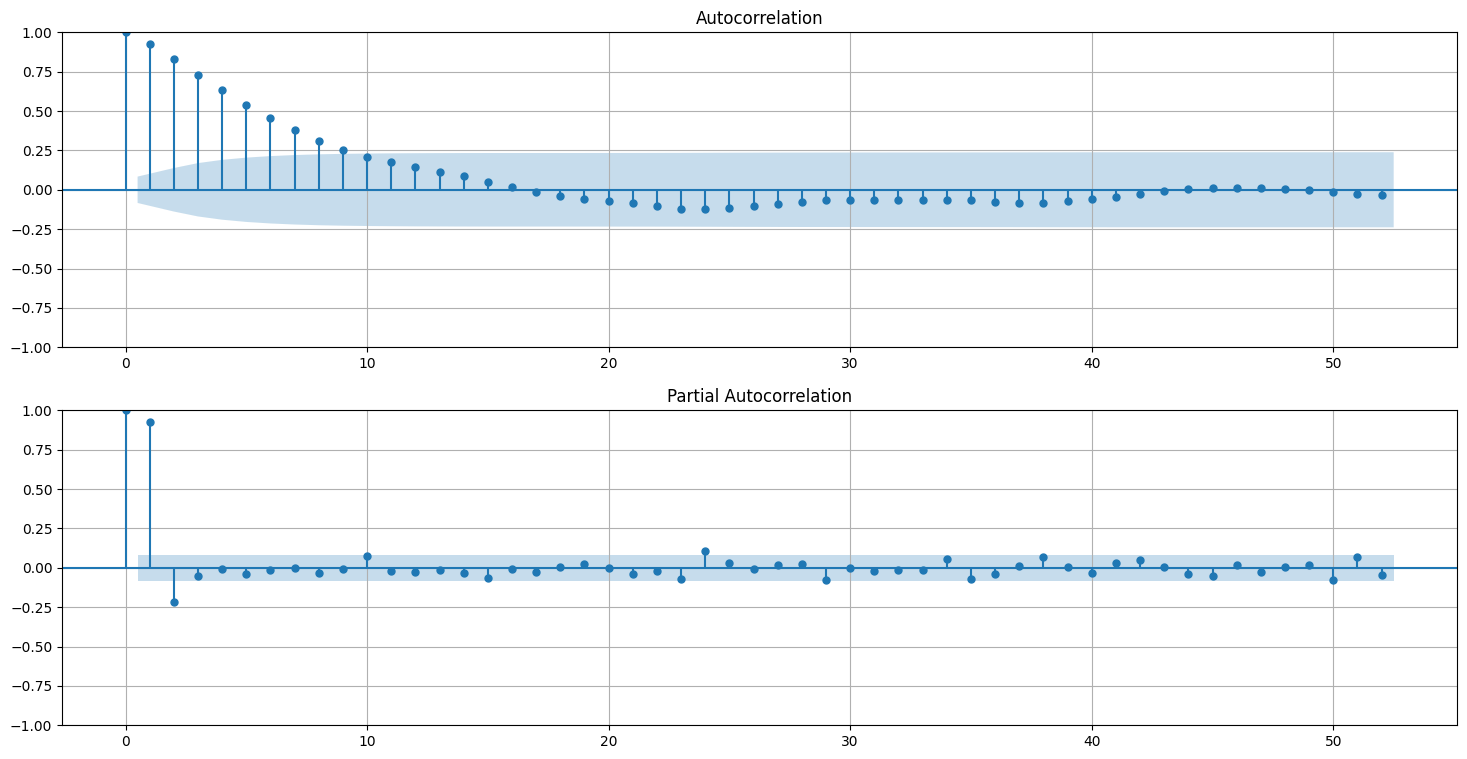

In [18]:
# Import libraries# Import 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Remove Nan values from the residuals
resid = residual.dropna()

# Examine acf and pacf for the smoothed residuals
plt.figure(figsize=(18,9))
plt.subplot(211)
plot_acf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.subplot(212)
plot_pacf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.show()

In [31]:
import pmdarima as pm

# Automatically determine the best ARIMA parameters
model = pm.auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:               SARIMAX(2, 2, 4)   Log Likelihood               -1892.698
Date:                Sun, 17 Nov 2024   AIC                           3799.396
Time:                        16:13:10   BIC                           3830.151
Sample:                    07-04-2010   HQIC                          3811.370
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3479      0.016    -22.322      0.000      -0.378      -0.317
ar.L2         -0.9290      0.013    -68.944      0.000      -0.955      -0.903
ma.L1         -0.3606      0.019    -19.414      0.0

In [34]:
results = model.predict(len(test))

In [37]:
# Load libraries
from statsmodels.tsa.arima.model import sarimax
from statsmodels.tsa.arima.model import ARIMA
import time

# Fit optimized ARIMA model:
model = sarimax.SARIMAX(train, order=model.order)
start = time.time() # record start time
model_fit = model.fit()
print('fitting complete after {} seconds'.format(time.time()-start)) # because the process takes time, w

/Users/manperumal/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27330D+00    |proj g|=  7.87587D+00

At iterate    5    f=  3.23818D+00    |proj g|=  3.00257D-01

At iterate   10    f=  3.18716D+00    |proj g|=  4.03244D-02

At iterate   15    f=  3.15950D+00    |proj g|=  9.08324D-02

At iterate   20    f=  3.15669D+00    |proj g|=  6.85777D-03

At iterate   25    f=  3.15596D+00    |proj g|=  8.97200D-02

At iterate   30    f=  3.15502D+00    |proj g|=  8.85631D-03

At iterate   35    f=  3.15496D+00    |proj g|=  9.67903D-03

At iterate   40    f=  3.15473D+00    |proj g|=  4.46667D-02

At iterate   45    f=  3.15455D+00    |proj g|=  2.13700D-03

At iterate   50    f=  3.15450D+00    |proj g|=  3.06940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/manperumal/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# forecast next year (52 cycles)
results = model_fit.forecast(len(test))

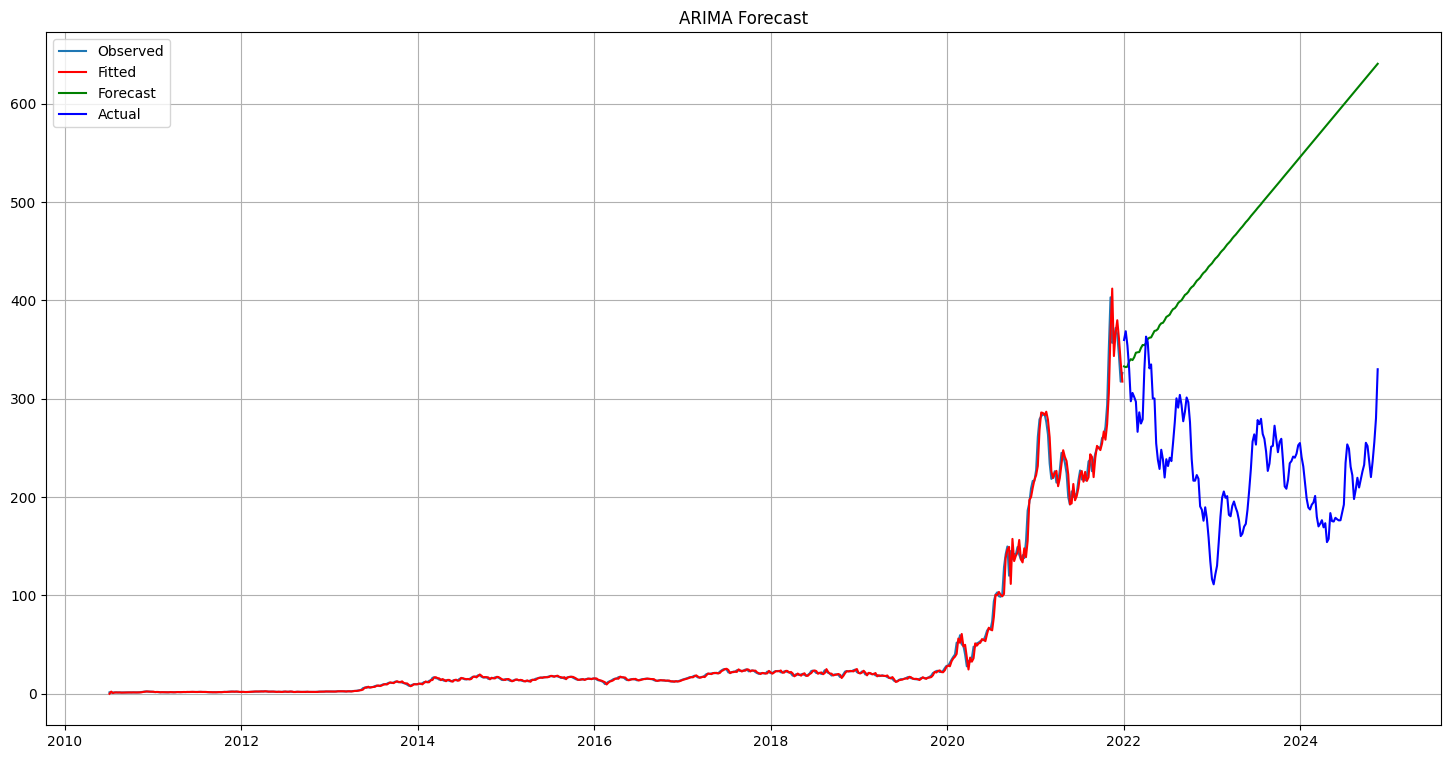

In [40]:
#  Plot forecasts 
plt.figure(figsize=(18,9))
plt.plot(train, label='Observed')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
plt.plot(results, color='green', label='Forecast')
plt.plot(test, color='blue', label='Actual')
plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.grid()
plt.show()

In [30]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adjusted Close   No. Observations:                  600
Model:               SARIMAX(2, 2, 4)   Log Likelihood               -1892.698
Date:                Sun, 17 Nov 2024   AIC                           3799.396
Time:                        15:58:55   BIC                           3830.151
Sample:                    07-04-2010   HQIC                          3811.370
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3479      0.016    -22.322      0.000      -0.378      -0.317
ar.L2         -0.9290      0.013    -68.944      0.000      -0.955      -0.903
ma.L1         -0.3606      0.019    -19.414      0.000      -0.397      -0.324
ma.L2          0.4356      0.010     41.683      0.000       0.415       0.456
ma.L3         -0.8387      0.009    -93.869      0.000      -0.856      -0.821
ma.L4         -0.2034      0.019    -10.872      0.000      -0.240      -0.167
sigma2        32.4190      0.549     59.003      0.000      31.342      33.496
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             24434.46
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             582.96   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

history = [x for x in train]
print(type(history))
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0)) # Every time we fit the model, we use the entire history it is wrong, we should use only the last 52 weeks
    model_fit = model.fit() # Model fit every time the entire history is not correct, we should only fit the last 52 weeks
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Testing Mean Squared Error: %.3f' % error)


<class 'list'>
Testing Mean Squared Error: 259.320


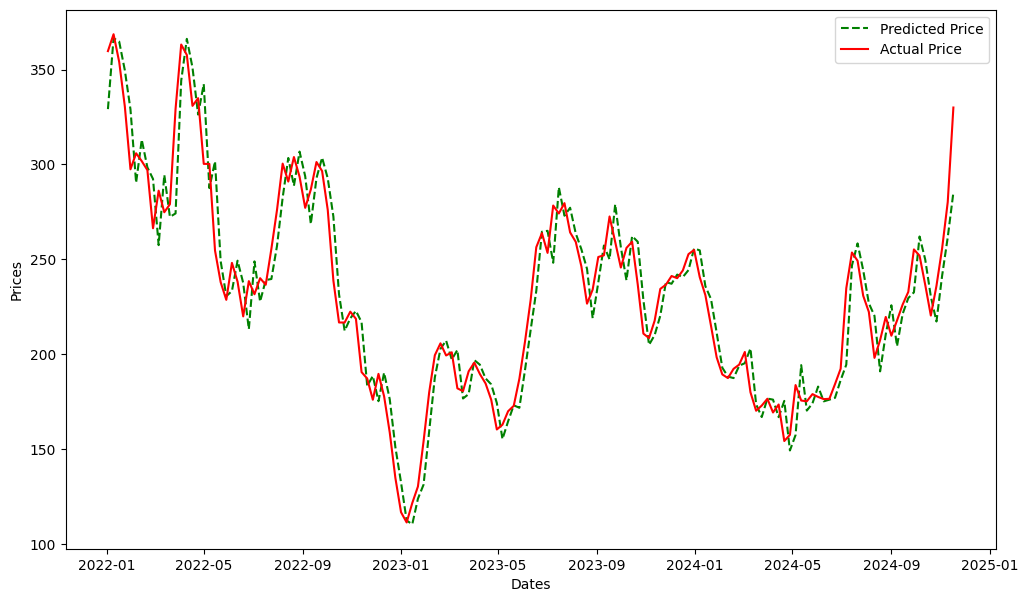

In [63]:
plt.figure(figsize=(12,7))
plt.plot(test.index, predictions, color='green', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test.index, test, color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

### Analysis:
 - Event though the above results, the preditction follows closely to the actual stock prices, it is not a good model for predicting stock prices. Becuase, it is just plotting the previous week stock prices as the future stock prices.